# import files

In [1]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert



In [2]:
import statistics


In [3]:
# xr.set_options(display_style="html")

# Read Fog file

In [4]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')



<xarray.DataArray 'fogdata' (years: 41)>
array([224., 205., 189., 191., 301., 198., 238., 263., 427., 275., 284.,
       259., 347., 356., 265., 372., 392., 415., 619., 527., 582., 449.,
       719., 503., 866., 813., 387., 447., 437., 488., 426., 543., 729.,
       533., 579., 781., 622., 818., 585., 602., 507.])
Coordinates:
  * years    (years) int32 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018 2019

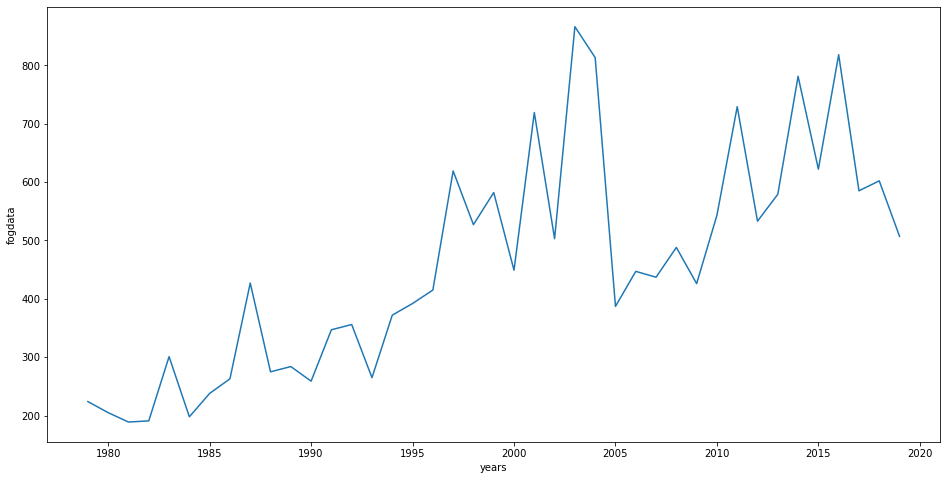

In [5]:
plt.figure(figsize=[16,8])

fogData.fogdata

fogData.fogdata.sum(dim=['stations','months','days']).plot()
fogData.fogdata.sum(dim=['stations','months','days'])


In [6]:
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog

<xarray.DataArray 'fogdata' (stations: 25, a: 2542)>
array([[ 0.,  1.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 1.,  0.,  0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  0.,  0., ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.]])
Coordinates:
  * stations  (stations) int32 42071 42101 42103 42131 ... 42492 42589 42591
  * a         (a) MultiIndex
  - years     (a) int64 1979 1979 1979 1979 1979 ... 2019 2019 2019 2019 2019
  - months    (a) int64 1 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
  - days      (a) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
Attributes:
    long_name:  fog presence (ncdc)

In [7]:
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
    

<xarray.DataArray 'time' (time: 2542)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31

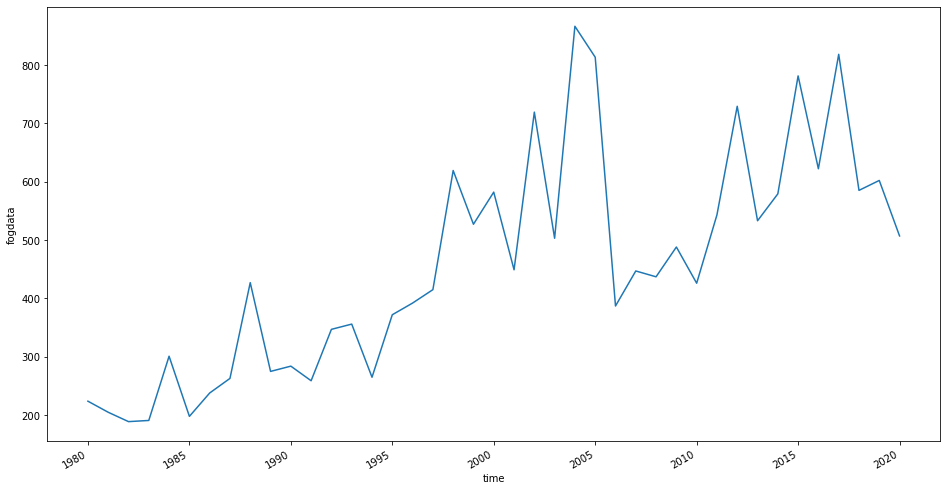

In [8]:
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
# fogData.fogdata.values.shape
# fogData.stations
plt.figure(figsize=[16,8])
fg.fogdata.resample(time="1y").sum().sum(dim='stations').plot()
fg.fogdata.time

# Read ERA5 Data

In [9]:
t2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_t2m_3hourly_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_u10_3hourly_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_v10_3hourly_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_d2m_3hourly_NovDecJan.nc')

In [10]:
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))

# Calculate wind speed and relative humidity

In [11]:
ws = ((v10D.v10[:,0,:,:].values**2)+(u10D.u10[:,0,:,:].values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
rh = (e**((17.625*(d2mD.d2m[:,0,:,:].values-273.15))/(243.04+(d2mD.d2m[:,0,:,:].values-273.15)))/e**((17.625*(t2mD.t2m[:,0,:,:].values-273.15))/(243.04+(t2mD.t2m[:,0,:,:].values-273.15))))
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
rh_ds
             
    

<xarray.Dataset>
Dimensions:    (latitude: 33, longitude: 49, time: 3859)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2020-12-26T10:30:00
  * latitude   (latitude) float32 32.0 31.75 31.5 31.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float32 74.0 74.25 74.5 74.75 ... 85.5 85.75 86.0
Data variables:
    rh         (time, latitude, longitude) float32 0.6722 0.706 ... nan nan

# Read 850 data

In [12]:
tz850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_tqz_3hourly_NovDecJan.nc')
uv850Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_850_uv_3hourly_NovDecJan.nc')
tz850D = tz850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
uv850D = uv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))

# Calculate inv

In [13]:
inv=t2mD.t2m[:,0,:,:].values-tz850D.t[:,0,:,:].values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'
#inv_ds.inv

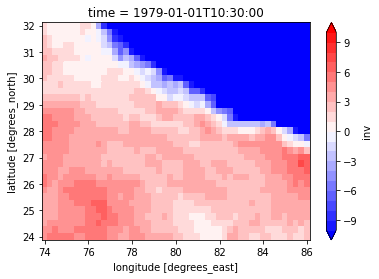

In [14]:
l = np.arange(-10,11,1)

inv_ds.inv[0,:,:].plot(levels=l,extend='both',cmap='bwr')

# u shear calculation

In [15]:
ushear=(uv850D.u[:,0,:,:].values-u10D.u10[:,0,:,:].values)/(tz850D.z[:,0,:,:].values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})

ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

ushear_ds.ushear
#inv

<xarray.DataArray 'ushear' (time: 3859, latitude: 33, longitude: 49)>
array([[[-1.0238177e-03, -1.2695988e-03, -1.3792079e-03, ...,
         -1.0881813e-05, -3.3778945e-06,  7.2031209e-05],
        [-6.4767484e-04, -8.6895743e-04, -1.0997297e-03, ...,
          5.7605455e-05, -3.7027788e-05, -3.1994703e-05],
        [-3.8303775e-04, -4.8575728e-04, -7.6003326e-04, ...,
         -3.1857249e-05, -6.8185400e-05, -1.4802489e-04],
        ...,
        [ 1.4826008e-03,  1.7028598e-03,  1.8336740e-03, ...,
          1.5490558e-03,  1.1645124e-03,  7.9129357e-04],
        [ 1.7984551e-03,  1.7813715e-03,  1.7603425e-03, ...,
          1.8201234e-03,  1.6204850e-03,  1.5456234e-03],
        [ 1.6448847e-03,  1.5619330e-03,  1.4999445e-03, ...,
          2.0708111e-03,  2.2732189e-03,  2.3733831e-03]],

       [[-1.4083405e-03, -1.7113702e-03, -1.7937745e-03, ...,
          9.9178897e-06, -4.6454502e-06,  1.3501594e-05],
        [-7.4590003e-04, -9.5193583e-04, -1.0730475e-03, ...,
          1.8146757e-05, -7.8385550e-05, -6.1385377e-05],
        [-9.4522773e-05, -1.9223751e-04, -4.0920082e-04, ...,
         -5.6274708e-05, -1.1326983e-04, -2.3669080e-04],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T10:30:00 ... 2020-12-26T10:30:00
  * latitude   (latitude) float32 32.0 31.75 31.5 31.25 ... 24.5 24.25 24.0
  * longitude  (longitude) float32 74.0 74.25 74.5 74.75 ... 85.5 85.75 86.0

# Read W700 

In [16]:
w700Data = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/DailyERA5IGP_700_w_3hourly_NovDecJan.nc')
w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))

# Read Orography


In [17]:
OroData = xr.open_dataset('../../../Data/IGPERA5/DailyFiles/ERA5IGP_Orography.nc')
OroData.data_vars
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

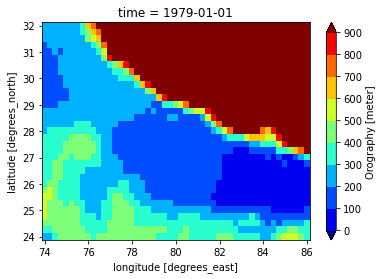

In [18]:
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
l = np.arange(0,1000,100)
oro[0,:,:].plot(levels=l,extend='both',cmap='jet')

# Create Mask altitude >500 m NaN

In [19]:
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values
# chk mask
t2mD.t2m.values=t2mD.t2m.values*mask
#t2mData.t2m[0,0,:,:].plot(cmap='jet')
#plt.figure(figsize=[20,10])
#t2mData.mean(dim=['latitude','longitude']).t2m[:,0].plot()
t2mTS=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m[:,0]


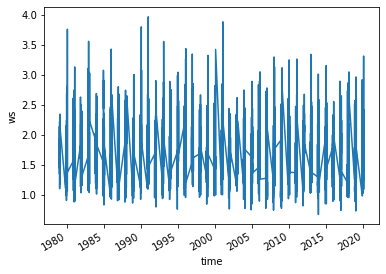

In [20]:
ws_ds.ws.values=ws_ds.ws.values*mask
wsTS=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
wsTS.plot()


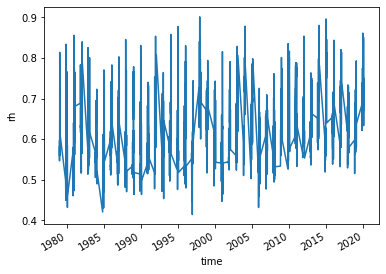

In [21]:
rh_ds.rh.values=rh_ds.rh.values*mask
rh_ds.rh[:].mean(dim=['latitude','longitude'], skipna=True).plot()


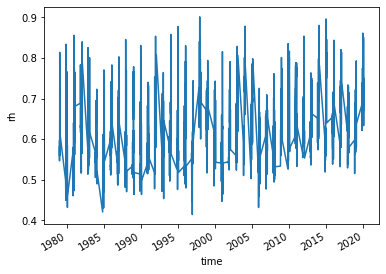

In [22]:
rhTS=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
rhTS.plot()

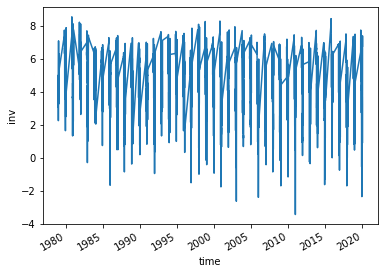

In [23]:
inv_ds.inv.values=inv_ds.inv.values*mask
invTS=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
invTS.plot()

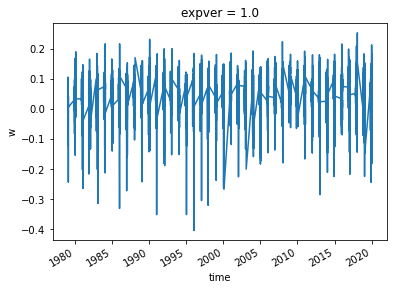

In [24]:
w700D.w.values=w700D.w.values*mask
w700D.mean(dim=['latitude','longitude'])
wTS=w700D.mean(dim=['latitude','longitude'], skipna=True).w[:,0]
wTS.plot()

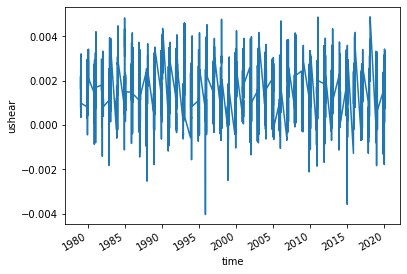

In [25]:
ushear_ds.ushear.values=ushear_ds.ushear.values*mask
ushearTS=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear
ushearTS.plot()

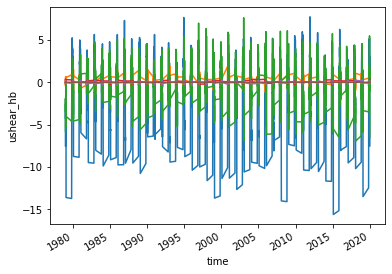

In [26]:

t2m_hb = np.imag(hilbert(t2mTS.values[(t2mTS.time.dt.year<2020)],axis=0))
t2m_hb_ds = xr.Dataset({'t2m_hb': (('time'), t2m_hb)}, coords={'time': t2mTS[(t2mTS.time.dt.year<2020)].time})
t2m_hb_ds.t2m_hb.plot()

ws_hb = np.imag(hilbert(wsTS.values[(wsTS.time.dt.year<2020)],axis=0))
ws_hb_ds = xr.Dataset({'ws_hb': (('time'), ws_hb)}, coords={'time': wsTS[(wsTS.time.dt.year<2020)].time})
ws_hb_ds.ws_hb.plot()

inv_hb = np.imag(hilbert(invTS.values[(invTS.time.dt.year<2020)],axis=0))
inv_hb_ds = xr.Dataset({'inv_hb': (('time'), inv_hb)}, coords={'time': invTS[(invTS.time.dt.year<2020)].time})
inv_hb_ds.inv_hb.plot()

rh_hb = np.imag(hilbert(rhTS.values[(rhTS.time.dt.year<2020)],axis=0))
rh_hb_ds = xr.Dataset({'rh_hb': (('time'), rh_hb)}, coords={'time': rhTS[(rhTS.time.dt.year<2020)].time})
rh_hb_ds.rh_hb.plot()

w_hb = np.imag(hilbert(wTS.values[(wTS.time.dt.year<2020)],axis=0))
w_hb_ds = xr.Dataset({'w_hb': (('time'), w_hb)}, coords={'time': wTS[(wTS.time.dt.year<2020)].time})
w_hb_ds.w_hb.plot()

ushear_hb = np.imag(hilbert(ushearTS.values[(ushearTS.time.dt.year<2020)],axis=0))
ushear_hb_ds = xr.Dataset({'ushear_hb': (('time'), ushear_hb)}, coords={'time': ushearTS[(ushearTS.time.dt.year<2020)].time})
ushear_hb_ds.ushear_hb.plot()


#  Create area averaged values and get same days as fog days i.e. Dec Jan

In [27]:
# a,b = xr.align(fg.fogdata.sum(dim='stations'),t2mTS)
t2mTS.values=t2mTS.values-np.nanmean(t2mTS.values)
wsTS.values=wsTS.values-np.nanmean(wsTS.values)
invTS.values=invTS.values-np.nanmean(invTS.values)
rhTS.values=rhTS.values-np.nanmean(rhTS.values)
wTS.values=wTS.values-np.nanmean(wTS.values)
ushearTS.values=ushearTS.values-np.nanmean(ushearTS.values)

t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
t2m

# fg.fogdata.sum(dim='stations')


<xarray.DataArray 't2m' (time: 2480)>
array([ 1.7182312,  1.739563 ,  1.4523621, ..., -4.069031 , -3.0302124,
       -1.6350403], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T10:30:00 ... 2019-01-31T10:30:00
    expver   float64 1.0

In [28]:
t2mTS.values=t2mTS.values-np.nanmean(t2mTS.values)


In [29]:
t2mhb=t2m_hb_ds.t2m_hb[((t2m_hb_ds.time.dt.month>11) | (t2m_hb_ds.time.dt.month<2)) & (t2m_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
invhb=inv_hb_ds.inv_hb[((inv_hb_ds.time.dt.month>11) | (inv_hb_ds.time.dt.month<2)) & (inv_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
wshb=ws_hb_ds.ws_hb[((ws_hb_ds.time.dt.month>11) | (ws_hb_ds.time.dt.month<2)) & (ws_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
rhhb=rh_hb_ds.rh_hb[((rh_hb_ds.time.dt.month>11) | (rh_hb_ds.time.dt.month<2)) & (rh_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
whb=w_hb_ds.w_hb[((w_hb_ds.time.dt.month>11) | (w_hb_ds.time.dt.month<2)) & (w_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))
ushearhb=ushear_hb_ds.ushear_hb[((ushear_hb_ds.time.dt.month>11) | (ushear_hb_ds.time.dt.month<2)) & (ushear_hb_ds.time.dt.year<2020)].sel(time=slice('1979-12-1','2019-1-31'))

In [30]:
 X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0,
                        t2mhb.values,wshb.values,rhhb.values,invhb.values,whb.values,ushearhb.values]).T[:]
 X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5,6,7,8,9,10,11
1979-12-01 10:30:00,1.718231,0.151693,0.078999,2.527771,0.054640,-0.061134,3.601676,0.038903,0.151368,-0.546599,-0.012106,2.694767e-04
1979-12-02 10:30:00,1.739563,-0.043712,0.036772,1.534163,0.011172,-0.042491,3.807217,0.014750,0.129374,-0.232700,0.019394,7.810135e-05
1979-12-03 10:30:00,1.452362,-0.091650,0.031268,1.367244,-0.005897,-0.046034,3.978152,0.250979,0.108878,-0.840632,0.030353,3.611430e-04
1979-12-04 10:30:00,0.891174,-0.558388,0.028077,1.546700,-0.059419,-0.064184,3.670383,0.096814,0.113694,-1.268006,0.036459,2.381015e-04
1979-12-05 10:30:00,1.426697,-0.515721,0.016754,2.821470,-0.087577,-0.058232,3.435389,-0.389744,0.105176,-1.139988,-0.038256,4.473547e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-27 10:30:00,-3.800201,0.767481,0.048708,2.859730,0.021041,-0.111716,-4.066776,-0.345171,0.117046,-1.452215,-0.046514,-3.247446e-04
2019-01-28 10:30:00,-4.062836,0.943366,-0.022688,2.410261,0.065785,-0.077605,-4.721529,0.235499,0.101919,-0.464942,-0.035040,2.617729e-04
2019-01-29 10:30:00,-4.069031,0.520947,-0.048826,0.660146,0.110044,-0.099950,-7.449386,0.970345,0.029601,-0.032698,0.067782,-9.638902e-08
2019-01-30 10:30:00,-3.030212,-0.413746,-0.039816,-0.531840,-0.046785,-0.103424,-8.406804,0.542304,-0.017982,-1.615669,0.191527,3.194514e-06


In [31]:
y=fg.fogdata.sum(dim='stations').sel(time=slice('1979-12-1','2019-1-31'))
y

<xarray.DataArray 'fogdata' (time: 2480)>
array([4., 3., 3., ..., 1., 1., 4.])
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2019-01-31

# Gradient Boosting 

In [32]:

f_imp=np.zeros((12,10))
train_score=[]
test_score=[]
seed(1)
ranD_State=[randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100),randint(0,100)]
for i in range(10):
        print(ranD_State[i])
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=ranD_State[i])
        reg= GradientBoostingRegressor(n_estimators=300, min_samples_leaf=20, max_depth= 3,learning_rate=0.04,random_state=0).fit(X_train, y_train)
        train_score.append(reg.score(X_train, y_train))
        test_score.append(reg.score(X_test, y_test))
        f_imp[:,i]=reg.feature_importances_
        #print(type(reg.feature_importances_))
        #print(reg.feature_importances_)
print(train_score)
print(test_score)
print(statistics.mean(train_score))
print(statistics.mean(test_score))



17
72
97
8
32
15
63
97
57
60
[0.7430811475799074, 0.7515106157570776, 0.7609636373057773, 0.7438776756704399, 0.7505975317188774, 0.7569469314024699, 0.7470102256223634, 0.7609636373057773, 0.7484785823942453, 0.7603670757570764]
[0.6124565454699138, 0.6145707889738126, 0.5766852186979641, 0.6272564143819075, 0.6216413382328851, 0.6322911740213433, 0.6123377639914194, 0.5766852186979641, 0.6472148086557634, 0.5298953480996292]
0.7523797060514013
0.6051034619222603


[[1.         0.84942827]
 [0.84942827 1.        ]]
[[1.         0.87510764]
 [0.87510764 1.        ]]
[[1.         0.73136728]
 [0.73136728 1.        ]]


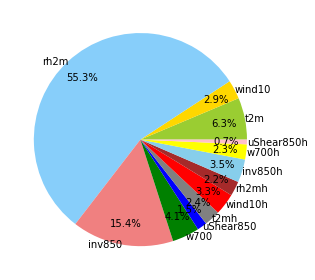

In [33]:

labels = ["t2m","wind10","rh2m","inv850","w700","uShear850","t2mh","wind10h","rh2mh",
          "inv850h","w700h","uShear850h"]
sizes = np.mean(f_imp, axis=1)
#print(sizes)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','green','blue','grey','red','brown','skyblue','yellow','pink']
plt.pie(sizes, labels=labels,colors=colors, autopct='%1.1f%%', pctdistance=0.8, labeldistance=1.0)

#patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
#plt.legend(patches, labels, loc="best")
#plt.axis('equal')
plt.tight_layout()
#plt.show()
plt.savefig('GradBoostAllDays.png')

y_pred=reg.predict(X)
y_pred_test=reg.predict(X_test)
y_pred_train=reg.predict(X_train)

print(np.corrcoef(y,y_pred))
print(np.corrcoef(y_train,y_pred_train))
print(np.corrcoef(y_test,y_pred_test))


np.savetxt("y_predGradBoost.txt",y_pred,fmt='%0.3f')
